# Ordinary kriging using pykrige

In [18]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Read in footfall data

2 different options for footfall stats to measure

### Option 1: Daily average footfall per sensor

In [77]:
daily_mean_footfall = pd.read_csv("Data/sensors_daily_means_with_features.csv")
daily_mean_footfall.head()

,sensor_id,DailyMean,betweenness,lights,street_inf,bikes,landmarks,memorials,trees,transport_stops,bus-stops,tram-stops,metro-stations,taxi-ranks,big-car-parks,buildings_2019,avg_n_floors_2019,Latitude,Longitude
0,8,3850.860663,0.024056,2335,793,3,6,2,2175,2,0,2,0,0,4,29,11.172414,-37.822935,144.947175
1,2,19708.038333,0.041181,551,1557,2,16,20,454,1,1,0,0,18,7,373,5.860590,-37.813807,144.965167
2,3,27519.236994,0.066600,498,1331,3,16,10,455,4,0,3,1,11,9,346,6.106936,-37.811015,144.964295
3,15,18026.084880,0.014960,501,1290,3,15,11,469,4,0,3,1,11,7,323,6.517028,-37.810644,144.964471
4,11,2195.141162,0.000074,1205,556,1,6,1,778,2,0,2,0,1,10,36,7.166667,-37.815650,144.939707


### Option 2: Footfall on a specifc day

In [42]:
daily_random_footfall = pd.read_csv("../MelbourneAnalysis/Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_400.csv")
daily_random_footfall = daily_random_footfall[daily_random_footfall.year == 2019]
daily_random_footfall = daily_random_footfall[daily_random_footfall.month_num == 10]
daily_random_footfall = daily_random_footfall[daily_random_footfall.day_of_month_num == 1]
daily_random_footfall = daily_random_footfall[daily_random_footfall.time == 12]
daily_random_footfall = daily_random_footfall.merge(pd.read_csv("../MelbourneAnalysis/Data/FootfallData/melbourne_locations.csv",
                                                                       index_col=0)[['Latitude', 'Longitude']] ,how='left', on='sensor_id')
# daily_random_footfall = daily_random_footfall[['Latitude', 'Longitude','DailyMean', 'buildings_2019', 'betweenness', 'landmarks', 'trees', 'memorials']]
daily_random_footfall.head()

,sensor_id,datetime,year,time,hourly_counts,time_of_day,day_of_month_num,weekday_num,month_num,Temp,...,month_12,Sin_time,Cos_time,Sin_month_num,Cos_month_num,Sin_weekday_num,Cos_weekday_num,distance_from_centre,Latitude,Longitude
0,10,2019-10-01 12:00:00,2019,12,523,morning,1,2,10,20.5,...,0,-0.136167,-0.990686,-0.866025,0.5,0.974928,-0.222521,1.521419,-37.818765,144.947105
1,42,2019-10-01 12:00:00,2019,12,451,morning,1,2,10,20.5,...,0,-0.136167,-0.990686,-0.866025,0.5,0.974928,-0.222521,1.350575,-37.800086,144.963864
2,12,2019-10-01 12:00:00,2019,12,371,morning,1,2,10,20.5,...,0,-0.136167,-0.990686,-0.866025,0.5,0.974928,-0.222521,1.723645,-37.814580,144.942924
3,31,2019-10-01 12:00:00,2019,12,405,morning,1,2,10,20.5,...,0,-0.136167,-0.990686,-0.866025,0.5,0.974928,-0.222521,1.225070,-37.801697,144.966589
4,39,2019-10-01 12:00:00,2019,12,1299,morning,1,2,10,20.5,...,0,-0.136167,-0.990686,-0.866025,0.5,0.974928,-0.222521,0.700535,-37.813797,144.969957


### Plot location of sensors and the region within which to make predictions

In [38]:
import folium

mapf = folium.Map(location=(-37.815908,144.966915), zoom_start=13)
for _, station in daily_random_footfall.iterrows():
    marker = folium.Marker(location=(station.Latitude, station.Longitude),
                                     weight=1, color="Green",
                                     tooltip=f"{station.sensor_id}")
    marker.add_to(mapf)

bound_map = ((42.3, -5), (51.1, 8.3))
bound_map = ((-37.79, 144.93), (-37.83, 144.985))

rect = folium.Rectangle(bound_map, color="Gray",
                        tooltip="Bounds for the temperature map to come")
rect.add_to(mapf)

mapf

## Choose which footfall to use 

In [78]:
data = daily_random_footfall #daily_mean_footfall
col_name = 'hourly_counts' #'DailyMean'

### Ordinary Kriging (ie not incorporating an external trend), no CV

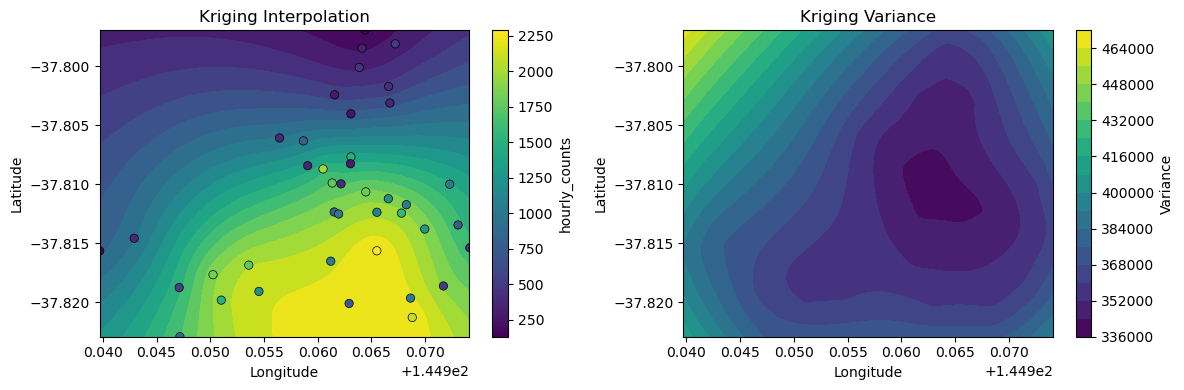

In [80]:
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt

# Set up the grid for kriging predictions
grid_resolution = 0.0001
grid_lat = np.arange(data['Latitude'].min(), data['Latitude'].max(), grid_resolution)
grid_lon = np.arange(data['Longitude'].min(), data['Longitude'].max(), grid_resolution)

# Create the OrdinaryKriging object with three variables
ok = OrdinaryKriging(
    data['Longitude'],
    data['Latitude'],
    data[col_name],
    variogram_model='linear',  # Choose the variogram model based on your analysis
    verbose=False,
    enable_plotting=False
)

# Perform kriging on the grid
z, ss = ok.execute('grid', grid_lon, grid_lat)

# Plot the kriged values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.contourf(grid_lon, grid_lat, z, cmap='viridis', levels=20)
# plt.pcolormesh(grid_lon, grid_lat, z, shading='auto')
plt.scatter(data['Longitude'], data['Latitude'], c=data[col_name], cmap='viridis', edgecolors='black', linewidth=0.5)
plt.colorbar(label=col_name)
plt.title('Kriging Interpolation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add original data points with labels
# for i, (lon, lat, daily_mean) in enumerate(zip(data['Longitude'], data['Latitude'], data['DailyMean'])):
#     plt.text(lon, lat, f'{daily_mean:.2f}', color='white', ha='center', va='center', fontsize=8)


# Plot the kriged variance
plt.subplot(1, 2, 2)
plt.contourf(grid_lon, grid_lat, ss, cmap='viridis', levels=20)
# plt.pcolormesh(grid_lon, grid_lat, ss, shading='auto')
plt.colorbar(label='Variance')
plt.title('Kriging Variance')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add original data points
# plt.scatter(data['Longitude'], data['Latitude'], c=data['DailyMean'], cmap='viridis', edgecolors='black', linewidth=0.5)

plt.tight_layout()
plt.show()


### Ordinary Kriging with Cross Validation

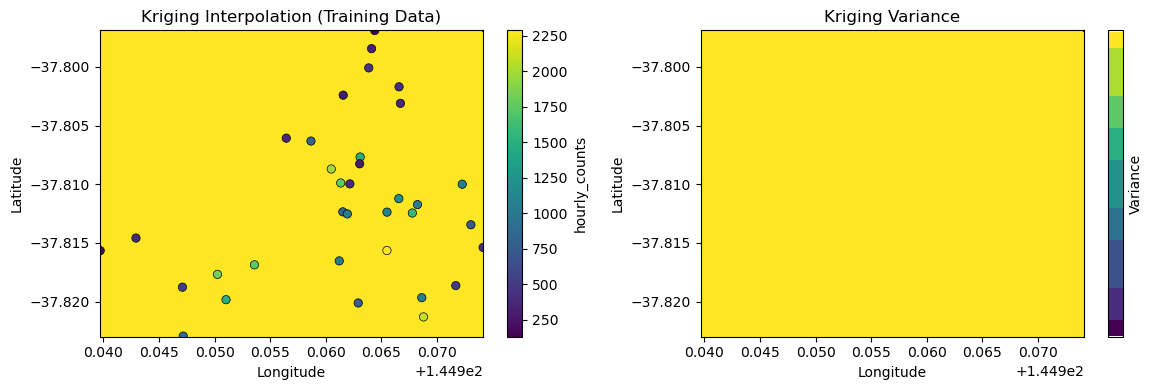

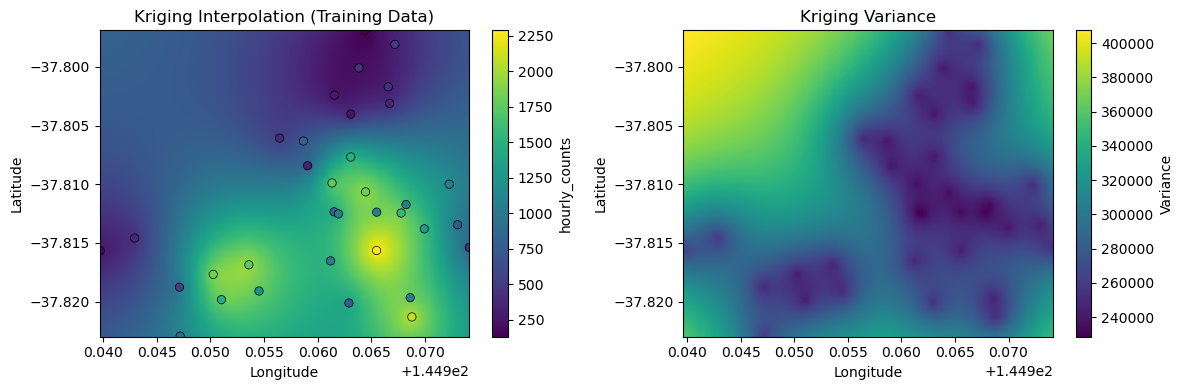

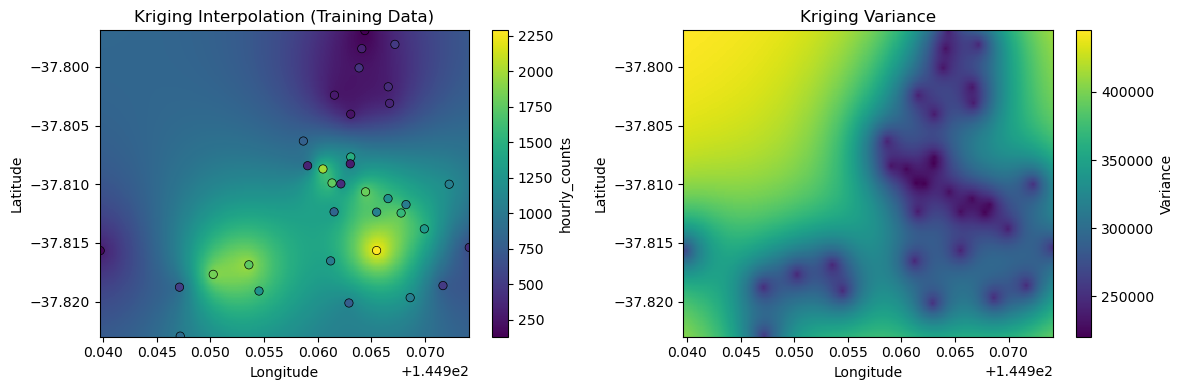

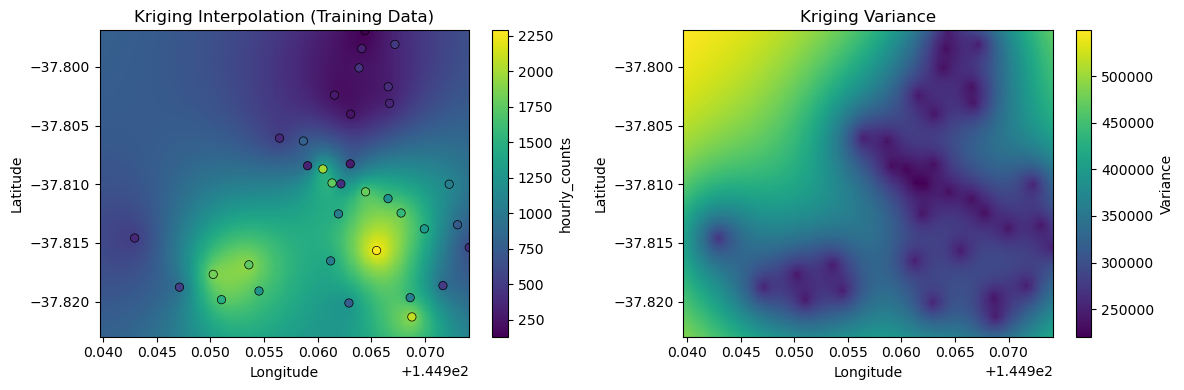

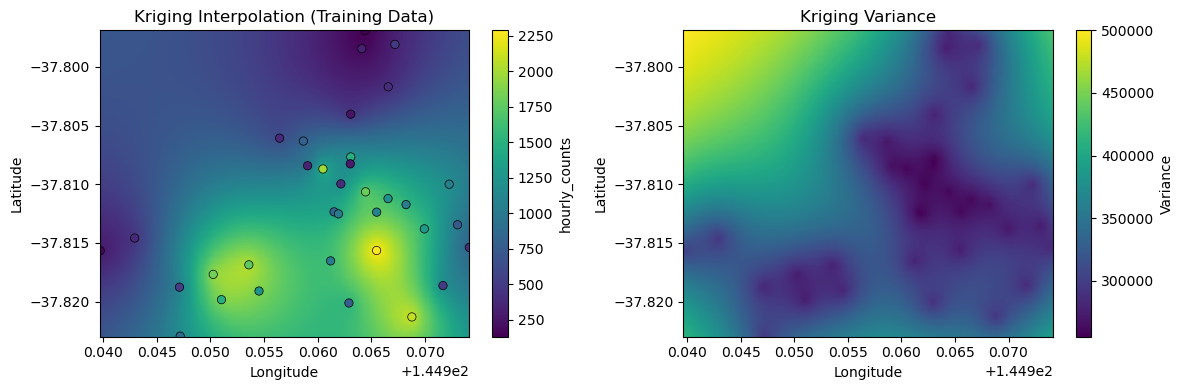

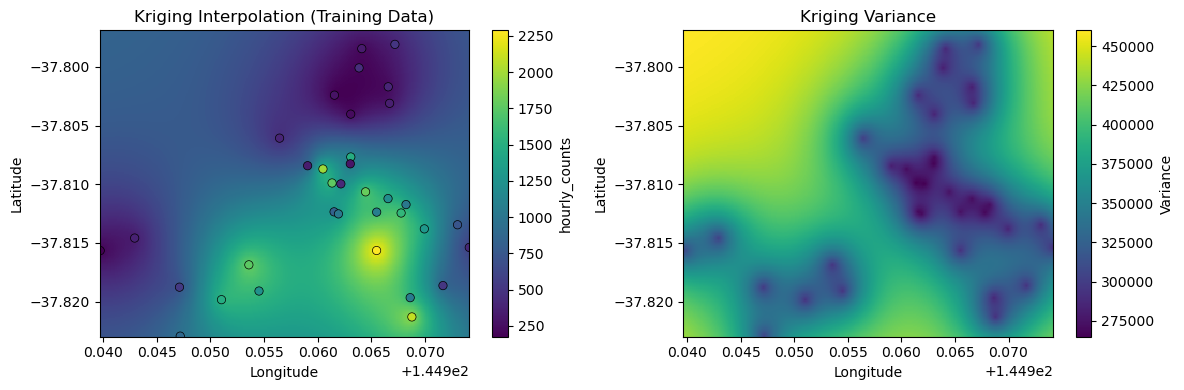

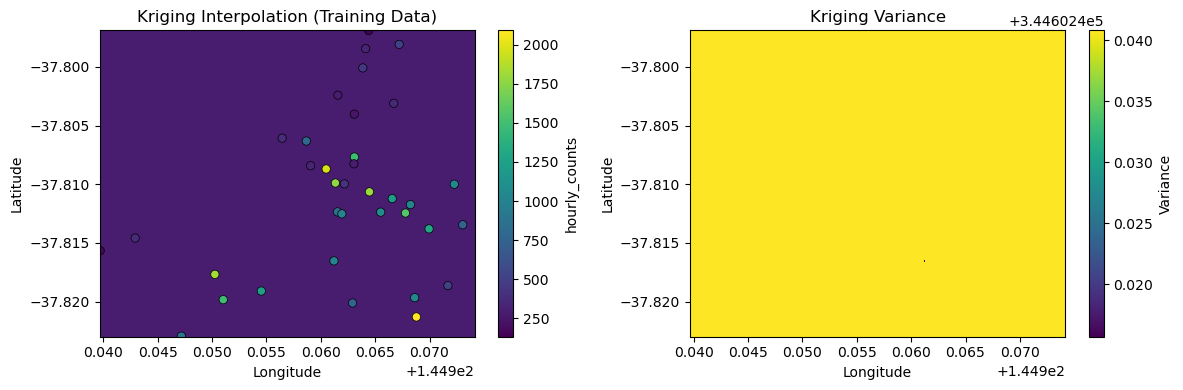

In [81]:
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Set up the grid for kriging predictions
grid_resolution = 0.0001
grid_lat = np.arange(data['Latitude'].min(), data['Latitude'].max(), grid_resolution)
grid_lon = np.arange(data['Longitude'].min(), data['Longitude'].max(), grid_resolution)

# Number of folds for cross-validation
n_folds = 7
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)

# Perform kriging with cross-validation
for train_index, test_index in kf.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

    # Create the OrdinaryKriging object with three variables
    ok = OrdinaryKriging(
        train_data['Longitude'],
        train_data['Latitude'],
        train_data[col_name],
        variogram_model='exponential',  # Choose the variogram model based on your analysis
        verbose=False,
        enable_plotting=False
    )

    # Perform kriging on the grid
    z, ss = ok.execute('grid', grid_lon, grid_lat)

    # Plot the kriged values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.pcolormesh(grid_lon, grid_lat, z, shading='auto')
    #plt.contourf(grid_lon, grid_lat, ss, cmap='viridis', levels=20)
    plt.scatter(train_data['Longitude'], train_data['Latitude'], c=train_data[col_name], cmap='viridis', edgecolors='black', linewidth=0.5)
    plt.colorbar(label=col_name)
    plt.title('Kriging Interpolation (Training Data)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Plot the kriged variance
    plt.subplot(1, 2, 2)
    #plt.contourf(grid_lon, grid_lat, ss, cmap='viridis', levels=20)
    plt.pcolormesh(grid_lon, grid_lat, ss, shading='auto')
    plt.colorbar(label='Variance')
    plt.title('Kriging Variance')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.tight_layout()
    plt.show()


### Universal Kriging with variables added, doesn't work with CV

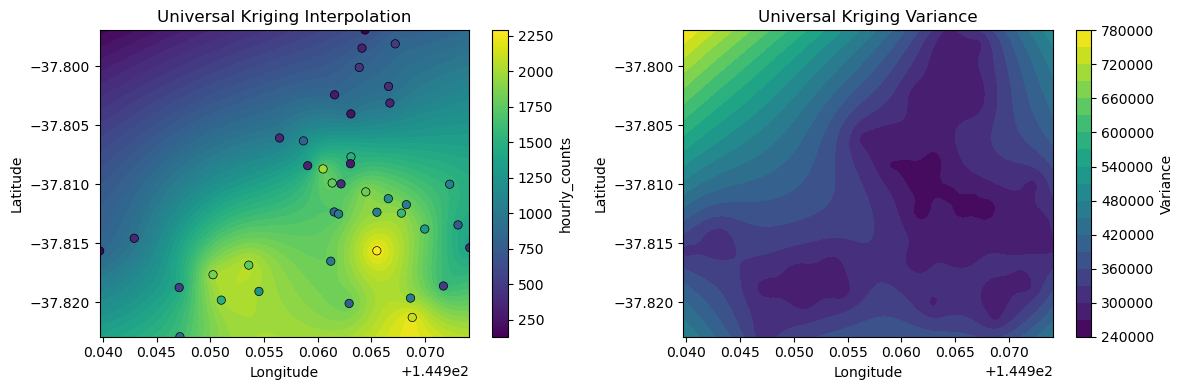

In [92]:
# Assuming 'data' is your DataFrame with columns: 'Longitude', 'Latitude', 'DailyMean', 'DistanceFromCentre'

# Set up the grid for kriging predictions
grid_resolution = 0.0001
grid_lat = np.arange(data['Latitude'].min(), data['Latitude'].max(), grid_resolution)
grid_lon = np.arange(data['Longitude'].min(), data['Longitude'].max(), grid_resolution)

# Create the UniversalKriging object with three variables
uk = UniversalKriging(
    data['Longitude'],
    data['Latitude'],
    data[col_name],
    variogram_model='exponential',  # Choose the variogram model based on your analysis
    # coordinates_type='geographic',
    drift_terms=['regional_linear', 'DistanceFromCentre', 'landmarks', 'memorials', 'distance_from_centre'],  # Additional variable for drift
    verbose=False,
    enable_plotting=False)

# Perform kriging on the grid
z, ss = uk.execute('grid', grid_lon, grid_lat)

# Plot the kriged values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.contourf(grid_lon, grid_lat, z, cmap='viridis', levels=50)
# plt.pcolormesh(grid_lon, grid_lat, z, shading='auto')
plt.scatter(data['Longitude'], data['Latitude'], c=data[col_name], cmap='viridis', edgecolors='black', linewidth=0.5)
plt.colorbar(label=col_name)
plt.title('Universal Kriging Interpolation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot the kriged variance
plt.subplot(1, 2, 2)
plt.contourf(grid_lon, grid_lat, ss, cmap='viridis', levels=20)
# plt.pcolormesh(grid_lon, grid_lat, ss, shading='auto')
plt.colorbar(label='Variance')
plt.title('Universal Kriging Variance')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

### Another option for doing this

In [93]:
import numpy as np
import pandas as pd
from pykrige.uk import UniversalKriging
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Set up the grid for kriging predictions with a finer resolution
grid_resolution = 0.0001
grid_lat = np.arange(data['Latitude'].min(), data['Latitude'].max(), grid_resolution)
grid_lon = np.arange(data['Longitude'].min(), data['Longitude'].max(), grid_resolution)

# Universal Kriging for spatial part
coordinates = data[['Longitude', 'Latitude']].values
values = data[col_name].values
uk = UniversalKriging(
    data['Longitude'],
    data['Latitude'],
    data[col_name],
    variogram_model='exponential',
    verbose=False,
    enable_plotting=False
)

# Perform prediction on the grid
spatial_part, _ = uk.execute('grid', grid_lon, grid_lat)

# Linear Regression for trend part with three auxiliary variables
trend_data = data[['landmarks', 'distance_from_centre']]
target = data[col_name].values  # Ensure this is a numpy array

# Create the grid for trend part with the finer resolution
trend_grid_lat = np.arange(data['Latitude'].min(), data['Latitude'].max(), grid_resolution)
trend_grid_lon = np.arange(data['Longitude'].min(), data['Longitude'].max(), grid_resolution)

# Make a meshgrid for trend grid
trend_grid_lon, trend_grid_lat = np.meshgrid(trend_grid_lon, trend_grid_lat)

# Flatten the trend grid for prediction
trend_grid = np.column_stack((trend_grid_lon.flatten(), trend_grid_lat.flatten()))

# Perform prediction on the trend grid
reg = LinearRegression().fit(trend_data, target)
trend_part = reg.predict(trend_grid)

# Combine spatial and trend parts
# z = spatial_part + trend_part.reshape(len(trend_grid_lat), len(trend_grid_lon))


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/kriging/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### Different option to plot

<Figure size 1200x400 with 0 Axes>

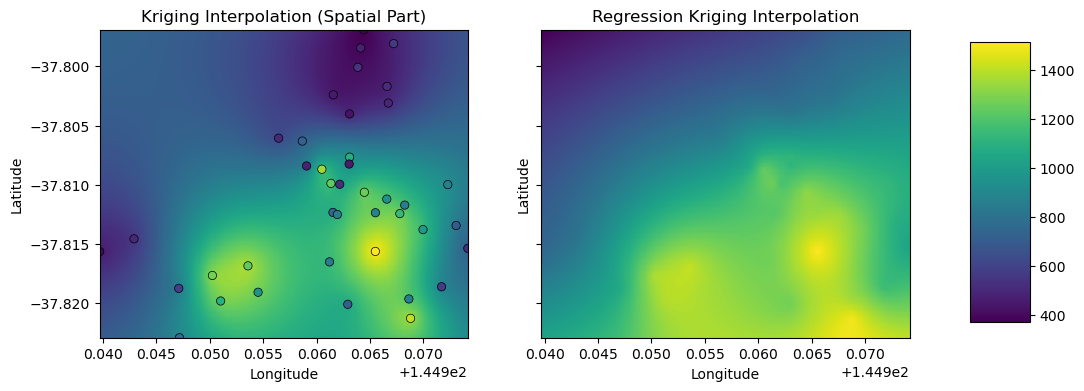

In [94]:
# Plot the kriged values with the same scale for both subplots
plt.figure(figsize=(12, 4))
fig, axs= plt.subplots(ncols=2, sharey=True, figsize = (12,4))

# plt.subplot(1, 2, 1)
im = axs[0].pcolormesh(grid_lon, grid_lat, spatial_part, shading='auto')
axs[0].scatter(data['Longitude'], data['Latitude'], c=data[col_name], cmap='viridis', edgecolors='black', linewidth=0.5)
# axs[0].colorbar(label='DailyMean')
axs[0].set_title('Kriging Interpolation (Spatial Part)')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].set_xlim(data['Longitude'].min(), data['Longitude'].max())
axs[0].set_ylim(data['Latitude'].min(), data['Latitude'].max())

axs[1].pcolormesh(trend_grid_lon, trend_grid_lat, z, shading='auto')
# axs[1].set_colorbar(label='DailyMean')
axs[1].set_title('Regression Kriging Interpolation')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].set_xlim(data['Longitude'].min(), data['Longitude'].max())
axs[1].set_ylim(data['Latitude'].min(), data['Latitude'].max())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# plt.tight_layout()
plt.show()